# Library

In [ ]:
pip install pyvi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 74.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 61.7 MB/s eta 0:00:00


In [ ]:
#pip install tensorflow-gpu==2.1

In [ ]:
pip install keras

# Data loader

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np

DATA = '/content/drive/MyDrive/BTL/MachineLearning/FinalTerm/ProcessingData/train.csv'
DEV_DATA = '/content/drive/MyDrive/BTL/MachineLearning/FinalTerm/ProcessingData/val.csv'
TEST_DATA = '/content/drive/MyDrive/BTL/MachineLearning/FinalTerm/ProcessingData/test.csv'

# read data
train_data = pd.read_csv(DATA)
dev_data = pd.read_csv(DEV_DATA)
test_data = pd.read_csv(TEST_DATA)

print(len(train_data))
print(len(dev_data))
print(len(test_data))

X_train = train_data['text']
y_train = train_data['label'].values

X_dev = dev_data['text']
y_dev = dev_data['label'].values

X_test = test_data['text']
y_test = test_data['label'].values

49321
6165
6166


In [ ]:
import pandas as pd
import numpy as np

from pyvi.ViTokenizer import ViTokenizer

# STOPWORDS = '/content/drive/MyDrive/MachineLearning/FinalTerm/ProcessingData/vietnamese-stopwords-dash.txt'
# with open(STOPWORDS, "r") as ins:
#     stopwords = []
#     for line in ins:
#         dd = line.strip('\n')
#         stopwords.append(dd)
#     stopwords = set(stopwords)

def filter_stop_words(train_sentences, stop_words):
    new_sent = [word for word in train_sentences.split() if word not in stop_words]
    train_sentences = ' '.join(new_sent)

    return train_sentences

def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

def preprocess(text, tokenized = True, lowercased = True):
    text = ViTokenizer.tokenize(text) if tokenized else text
    # text = filter_stop_words(text, stopwords)
    text = deEmojify(text)
    text = text.lower() if lowercased else text
    return text

In [ ]:
# --------------TRICH XUAT DAC TRUNG -------------------------
def pre_process_features(X, y, tokenized = True, lowercased = True):
    X = [preprocess(str(p), tokenized = tokenized, lowercased = lowercased) for p in list(X)]
    for idx, ele in enumerate(X):
        if not ele:
            np.delete(X, idx)
            np.delete(y, idx)
    return X, y

# Run models

## Text CNN (Convolutional neural network for text classification)

In [ ]:
import keras
print(keras.__version__)

3.4.1


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
# Text CNN
import pandas as pd
import numpy as np
import re
import pickle

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

from keras.layers import Input, Dense, Embedding, Conv2D, MaxPool2D
from keras.layers import Reshape, Flatten, Dropout, Concatenate
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.models import Model
from keras.utils import to_categorical
from tensorflow.keras.preprocessing import text, sequence
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

In [ ]:
train_X, train_y = pre_process_features(X_train, y_train, tokenized=True, lowercased = True)
dev_X, dev_y = pre_process_features(X_dev, y_dev, tokenized=True, lowercased = True)
test_X, test_y = pre_process_features(X_test, y_test, tokenized=True, lowercased = True)

EMBEDDING_FILE = 'drive/My Drive/BTL/CODE/HSD/embedding/cc.vi.300.vec'
MODEL_FILE = '/content/drive/MyDrive/BTL/MachineLearning/FinalTerm/TextCNN/Text_CNN_model_v13.h5'

def make_featues(X, y, tokenizer, is_one_hot_label=True):
    X = tokenizer.texts_to_sequences(X)
    #X = sequence.pad_sequences(X, maxlen=sequence_length)
    X = pad_sequences(X, maxlen=sequence_length)
    if is_one_hot_label:
        y = to_categorical(y, num_classes=2)

    return X, y

vocabulary_size = 10000
sequence_length = 100

embedding_dim = 300
batch_size = 256
epochs = 40
drop = 0.5

filter_sizes = [2,3,5]
num_filters = 32

In [ ]:
# --------------LOAD WORD EMBEDDING -------------------------
embeddings_index = {}
with open(EMBEDDING_FILE, encoding='utf8') as f:
    for line in f:
        values = line.rstrip().rsplit(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs


tokenizer = text.Tokenizer(lower=False, filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n')
tokenizer.fit_on_texts(train_X)

In [ ]:
#with open('drive/My Drive/CODE/HSD/tokenizer.pickle', 'wb') as handle:
#    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

word_index = tokenizer.word_index
# num_words = min(vocabulary_size, len(word_index) + 1)
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if i >= vocabulary_size:
        continue

    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
# Make features
train_X, train_y = make_featues(train_X, train_y, tokenizer)
dev_X, dev_y = make_featues(dev_X, dev_y, tokenizer)
test_X, test_y = make_featues(test_X, test_y, tokenizer, is_one_hot_label=False)

In [ ]:
inputs = Input(shape=(sequence_length,), dtype='int32')
embedding = Embedding(input_dim=num_words, output_dim=embedding_dim, input_length=sequence_length, weights=[embedding_matrix])(inputs)
reshape = Reshape((sequence_length,embedding_dim,1))(embedding)

conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], embedding_dim), padding='valid', kernel_initializer='normal', activation='elu')(reshape)
conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], embedding_dim), padding='valid', kernel_initializer='normal', activation='elu')(reshape)
conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], embedding_dim), padding='valid', kernel_initializer='normal', activation='elu')(reshape)

maxpool_0 = MaxPool2D(pool_size=(sequence_length - filter_sizes[0] + 1, 1), strides=(1,1), padding='valid')(conv_0)
maxpool_1 = MaxPool2D(pool_size=(sequence_length - filter_sizes[1] + 1, 1), strides=(1,1), padding='valid')(conv_1)
maxpool_2 = MaxPool2D(pool_size=(sequence_length - filter_sizes[2] + 1, 1), strides=(1,1), padding='valid')(conv_2)

concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])
flatten = Flatten()(concatenated_tensor)
dropout = Dropout(drop)(flatten)
output = Dense(units=2, activation='softmax')(dropout)

# this creates a model that includes
model = Model(inputs=inputs, outputs=output)

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 100)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_5 (Embedding)   │ (None, 100, 300)       │     11,305,800 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_2 (Reshape)       │ (None, 100, 300, 1)    │              0 │ embedding_5[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 99, 1, 32)      │         19,232 │ reshape_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 98, 1, 32)      │         28,832 │ reshape_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 96, 1, 32)      │         48,032 │ reshape_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 1, 1, 32)       │              0 │ conv2d_6[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_7           │ (None, 1, 1, 32)       │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_8           │ (None, 1, 1, 32)       │              0 │ conv2d_8[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_5             │ (None, 3, 1, 32)       │              0 │ max_pooling2d_6[0][0], │
│ (Concatenate)             │                        │                │ max_pooling2d_7[0][0], │
│                           │                        │                │ max_pooling2d_8[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_2 (Flatten)       │ (None, 96)             │              0 │ concatenate_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 96)             │              0 │ flatten_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 2)              │            194 │ dropout_2[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 11,402,090 (43.50 MB)

 Trainable params: 11,402,090 (43.50 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


193/193 ━━━━━━━━━━━━━━━━━━━━ 31s 79ms/step - accuracy: 0.6539 - loss: 0.6473 - val_accuracy: 0.7442 - val_loss: 0.5261
Epoch 2/40
193/193 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - accuracy: 0.7562 - loss: 0.5244 - val_accuracy: 0.7833 - val_loss: 0.4732
Epoch 3/40
193/193 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.7924 - loss: 0.4656 - val_accuracy: 0.8073 - val_loss: 0.4291
Epoch 4/40
193/193 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.8183 - loss: 0.4154 - val_accuracy: 0.8234 - val_loss: 0.3983
Epoch 5/40
193/193 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.8362 - loss: 0.3780 - val_accuracy: 0.8394 - val_loss: 0.3787
Epoch 6/40
193/193 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.8506 - loss: 0.3495 - val_accuracy: 0.8474 - val_loss: 0.3651
Epoch 7/40
193/193 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.8619 - loss: 0.3239 - val_accuracy: 0.8543 - val_loss: 0.3562
Epoch 8/40
193/193 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.8725 - loss: 0.3011 - val_accuracy: 0.8

[[4092  463]
 [ 576 1035]]
F1 - micro: 0.831495296788842
F1 - macro: 0.7765778960237818
Accuracy: 0.831495296788842


<Axes: >

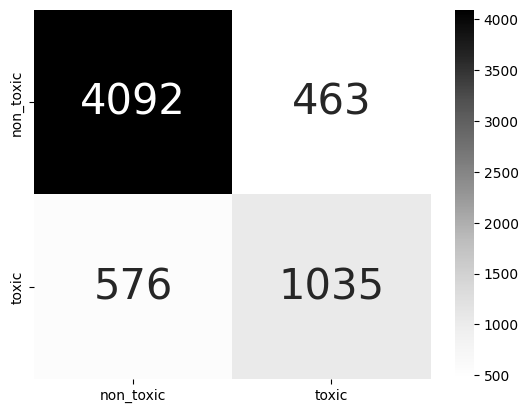

In [ ]:
# checkpoint = ModelCheckpoint('weights.{epoch:03d}-{val_acc:.4f}.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto')
adam = Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

model.fit(train_X, train_y, batch_size=batch_size, epochs=epochs, verbose=1,
          validation_data=(dev_X, dev_y))
model.save(MODEL_FILE)

prediction = model.predict(test_X, batch_size=batch_size, verbose=0)
y_pred = prediction.argmax(axis=-1)

cf1 = confusion_matrix(test_y, y_pred)
print(cf1)

evaluation = f1_score(test_y, y_pred, average='micro')

print("F1 - micro: " + str(evaluation))

evaluation = f1_score(test_y, y_pred, average='macro')
print("F1 - macro: " + str(evaluation))

evaluation = accuracy_score(test_y, y_pred)
print("Accuracy: " + str(evaluation))

df_cm1 = pd.DataFrame(cf1, index = ["non_toxic","toxic"],
                  columns = ["non_toxic","toxic"])
plt.clf()
sn.heatmap(df_cm1, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 30})

In [ ]:
from sklearn.metrics import classification_report
# The final score in the test set (classification report)

print(classification_report(y_pred,y_test, digits = 4))

              precision    recall  f1-score   support

           0     0.8984    0.8766    0.8873      4668
           1     0.6425    0.6909    0.6658      1498

    accuracy                         0.8315      6166
   macro avg     0.7704    0.7838    0.7766      6166
weighted avg     0.8362    0.8315    0.8335      6166



## GRU (Gated Recurrent Units)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 100)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_2 (Embedding)   │ (None, 100, 300)       │     11,305,800 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spatial_dropout1d_2       │ (None, 100, 300)       │              0 │ embedding_2[0][0]      │
│ (SpatialDropout1D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_2           │ (None, 100, 160)       │        183,360 │ spatial_dropout1d_2[0… │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 160)            │              0 │ bidirectional_2[0][0]  │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_2    │ (None, 160)            │              0 │ bidirectional_2[0][0]  │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 320)            │              0 │ global_average_poolin… │
│ (Concatenate)             │                        │                │ global_max_pooling1d_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 2)              │            642 │ concatenate_2[0][0]    │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 11,489,802 (43.83 MB)

 Trainable params: 11,489,802 (43.83 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


193/193 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.7287 - loss: 0.5905 - val_accuracy: 0.7395 - val_loss: 0.5372
Epoch 2/40
193/193 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.7556 - loss: 0.5121 - val_accuracy: 0.8109 - val_loss: 0.4312
Epoch 3/40
193/193 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.8239 - loss: 0.4058 - val_accuracy: 0.8347 - val_loss: 0.3847
Epoch 4/40
193/193 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.8527 - loss: 0.3488 - val_accuracy: 0.8469 - val_loss: 0.3673
Epoch 5/40
193/193 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.8690 - loss: 0.3122 - val_accuracy: 0.8509 - val_loss: 0.3631
Epoch 6/40
193/193 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.8839 - loss: 0.2854 - val_accuracy: 0.8521 - val_loss: 0.3626
Epoch 7/40
193/193 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - accuracy: 0.8957 - loss: 0.2593 - val_accuracy: 0.8548 - val_loss: 0.3673
Epoch 8/40
193/193 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.9064 - loss: 0.2379 - val_accuracy: 

[[4041  514]
 [ 601 1010]]
F1 - micro: 0.8191696399610768
F1 - macro: 0.7615514663178947
Accuracy: 0.8191696399610768


<Axes: >

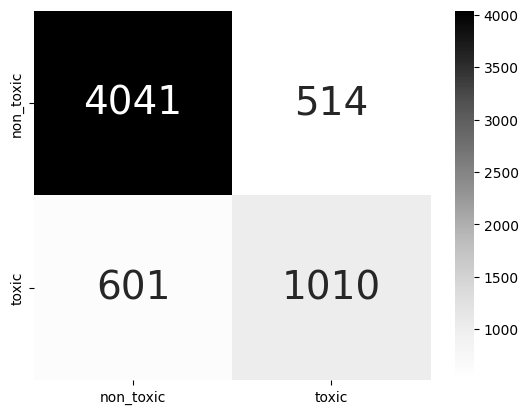

In [ ]:
# GRU
import pandas as pd
import numpy as np
import re
import pickle

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

from keras.layers import Dense, Input, Bidirectional, GRU
from keras.layers import Embedding
# from keras.preprocessing import text, sequence
from tensorflow.keras.preprocessing import text, sequence
from keras.layers import GlobalMaxPooling1D, GlobalAveragePooling1D, concatenate, SpatialDropout1D
from keras.models import Model
from keras import backend as K
from keras.utils import to_categorical
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

from pyvi.ViTokenizer import ViTokenizer

train_X, train_y = pre_process_features(X_train, y_train, tokenized=True, lowercased = True)
dev_X, dev_y = pre_process_features(X_dev, y_dev, tokenized=True, lowercased = True)
test_X, test_y = pre_process_features(X_test, y_test, tokenized=True, lowercased = True)

EMBEDDING_FILE = 'drive/My Drive/BTL/CODE/HSD/embedding/cc.vi.300.vec'
MODEL_FILE = 'drive/My Drive/BTL/CODE/HSD/model/GRU_model_v4.h5'

def make_featues(X, y, tokenizer, is_one_hot_label=True):
    X = tokenizer.texts_to_sequences(X)
    X = sequence.pad_sequences(X, maxlen=sequence_length)
    if is_one_hot_label:
        y = to_categorical(y, num_classes=2)

    return X, y

vocabulary_size = 10000
sequence_length = 100

embedding_dim = 300
batch_size = 256
epochs = 40
drop = 0.5

embeddings_index = {}
with open(EMBEDDING_FILE, encoding='utf8') as f:
    for line in f:
        values = line.rstrip().rsplit(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

tokenizer = text.Tokenizer(lower=False, filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n')
tokenizer.fit_on_texts(train_X)
with open('drive/My Drive/BTL/CODE/HSD/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# --------------LOAD WORD EMBEDDING-------------------------
word_index = tokenizer.word_index
# num_words = min(vocabulary_size, len(word_index) + 1)
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if i >= vocabulary_size:
        continue

    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

train_X, train_y = make_featues(train_X, train_y, tokenizer)
dev_X, dev_y = make_featues(dev_X, dev_y, tokenizer)
test_X, test_y = make_featues(test_X, test_y, tokenizer, is_one_hot_label=False)

input = Input(shape=(sequence_length,))
x = Embedding(num_words, embedding_dim, weights=[embedding_matrix])(input)
x = SpatialDropout1D(0.2)(x)
x = Bidirectional(GRU(80, return_sequences=True))(x)
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
conc = concatenate([avg_pool, max_pool])
output = Dense(2, activation="softmax")(conc)

# this creates a model that includes
model = Model(inputs=input, outputs=output)

model.summary()

# checkpoint = ModelCheckpoint('weights.{epoch:03d}-{val_acc:.4f}.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto')
adam = Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

model.fit(train_X, train_y, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(dev_X, dev_y))
model.save(MODEL_FILE)

prediction = model.predict(test_X, batch_size=batch_size, verbose=0)
y_pred = prediction.argmax(axis=-1)

cf2 = confusion_matrix(test_y, y_pred)
print(cf2)

evaluation = f1_score(test_y, y_pred, average='micro')

print("F1 - micro: " + str(evaluation))

evaluation = f1_score(test_y, y_pred, average='macro')
print("F1 - macro: " + str(evaluation))

evaluation = accuracy_score(test_y, y_pred)
print("Accuracy: " + str(evaluation))

df_cm2 = pd.DataFrame(cf2, index = ["non_toxic","toxic"],
                  columns = ["non_toxic","toxic"])
plt.clf()
sn.heatmap(df_cm2, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 28})